In [1]:
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

from a_api import TextMetrics, load_ngrams
from plot import plot_dict, plot_dict_bars, matrix_plot
from util import dictcount

grand_t0 = dt.datetime.now()

# Create Datasets
## Merge original binary and multiclass datasets into one

In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


In [3]:
df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = df2
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [17]:
l_no_distorted = len(df3[df3['Dominant Distortion']=='No Distortion'])
l_distorted = len(df3[df3['Dominant Distortion']!='No Distortion'])
print(len(df3),l_distorted,l_no_distorted,round(float(l_distorted)/len(df3),2),round(float(l_no_distorted)/len(df3),2))

2530 1597 933 0.63 0.37


## Create 3 split datasets for evaluation
### Check the label probaility distributions 

In [5]:
print('Full set',len(df3))
df_test = df3[df3.index % 10 == 0]
print('Test set',len(df_test))
df_test = df_test.reset_index()
df_test

Full set 2530
Test set 253


,index,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,10,My husband and I have been married for over a ...,"I thought that he displayed traits of honor, l...",Labeling,NaN
2,20,I have always suffered from performance anxiet...,During this time I was recruited to many great...,Fortune-telling,NaN
3,30,"As I’ve been becoming older, I’ve been getting...",But sometimes I can’t help what I say to my pa...,Emotional Reasoning,All-or-nothing thinking
4,40,I have been married for 15 years. I have grown...,I have grown very much but he has not. He will...,Labeling,Overgeneralization
...,...,...,...,...,...
248,2480,From 15-year-old girl in Canada: Recently I fe...,Recently I felt like my parents really hate me.,Mind Reading,NaN
249,2490,I used to get many strange looks for the thing...,NaN,No Distortion,NaN
250,2500,I can remember at least 3 incidents as a child...,NaN,No Distortion,NaN
251,2510,From the U.S.: I’ve been diagnosed with OCD si...,"Lately, I’ve been feeling like someone is watc...",Emotional Reasoning,NaN


In [18]:
df_tests= [
    df_test[df_test.index % 3 == 1],
    df_test[df_test.index % 3 == 2],
    df_test[df_test.index % 3 == 0],
]
for df in df_tests + [df_test,df3]:
    l_no_distorted = len(df[df['Dominant Distortion']=='No Distortion'])
    l_distorted = len(df[df['Dominant Distortion']!='No Distortion'])
    print(len(df),l_distorted,l_no_distorted,round(float(l_distorted)/len(df),2),round(float(l_no_distorted)/len(df),2))


84 58 26 0.69 0.31
84 62 22 0.74 0.26
85 47 38 0.55 0.45
253 167 86 0.66 0.34
2530 1597 933 0.63 0.37


# Create Evaluation Functions

In [7]:
def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_tm_any(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_tm_avg(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

def our_evaluator_tm_true(tm,text,threshold):
    return True
    
def our_evaluator_tm_false(tm,text,threshold):
    return False

def our_evaluator_tm_random(tm,text,threshold):
    return random.choice([True, False])

def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df_counts(df,tm,evaluator,threshold,debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(tm,text,threshold)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_tm_df(df,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,tm,evaluator,threshold,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def evaluate_tm_df_acc_f1(df,tm,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_tm_df_counts(df,tm,evaluator,threshold,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def agg_min_max_avg_mpe(runs):
    max_v = max(runs)
    min_v = min(runs)
    avg_v = sum(runs)/len(runs)
    # https://en.wikipedia.org/wiki/Mean_absolute_error
    mpe_v = sum([abs(v-avg_v) for v in runs])/len(runs)/avg_v*100 if avg_v > 0 else 0
    return min_v, max_v, avg_v, mpe_v


# Evaluate Different Models
## Evaluate All "Ours" Models without of Splits


In [8]:
models = {}

models['Ours base (binary: distortions and emotions), log'] = TextMetrics(language_metrics('',['distortions-all-emotions'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

models['Ours base (binary: distortions and negative emotions), log'] = TextMetrics(language_metrics('',['distortions-negative-emotions'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

models['Ours base (binary: distortions only), log'] = TextMetrics(language_metrics('',['distortions-only'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

models['Ours base (multi-class: distortions and emotions), log'] = TextMetrics(language_metrics('',['positive','negative','rude',
                                            'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning',
                                            'fortune-telling','labeling','magnification','mental-filtering','mindreading',
                                            'overgeneralizing','personalizing','should-statement'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

models['Ours base (multi-class: distortions and emotions), no log'] = TextMetrics(language_metrics('',['positive','negative','rude',
                                            'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning',
                                            'fortune-telling','labeling','magnification','mental-filtering','mindreading',
                                            'overgeneralizing','personalizing','should-statement'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=False,debug=False)

models['Ours new (binary), log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/shreevastava_2021_binary/first_split'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (binary), no log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/shreevastava_2021_binary/first_split'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)

models['Ours new (multi-class), log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/shreevastava_2021_multiclass/first_split'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class), no log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/shreevastava_2021_multiclass/first_split'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


In [41]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()

def test_evaluate_df(df_eval):
    thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    models_results = {}
    models_acc = []
    models_f1 = []
    
    for model in [m for m in models]:
        for evaluator in [our_evaluator_tm_any,our_evaluator_tm_avg] if 'multi-class' in model else [our_evaluator_tm_any]:
            evalname = 'any' if evaluator == our_evaluator_tm_any else 'avg' 
            print(f'{model}, {evalname}')
            best_t = 0
            best_acc = 0
            best_f1 = 0
            res_acc = {}
            res_f1 = {}
            for t in thresholds:
                acc, f1 = evaluate_tm_df_acc_f1(df_eval,models[model],evaluator,t,debug=False)
                if acc > best_acc:
                    best_t = t
                    best_acc = acc
                    best_f1 = f1
                res_acc[t] = acc
                res_f1[t] = f1
                print(model, t, acc, f1)
            models_acc.append([round(res_acc[t],2) for t in thresholds])
            models_f1.append([round(res_f1[t],2) for t in thresholds])
            t0 = dt.datetime.now()
            acc, f1 = evaluate_tm_df_acc_f1(df_eval,models[model],our_evaluator_tm_any,best_t,debug=False)
            t1 = dt.datetime.now()
            delta = t1 - t0
            print(model, best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
            models_results[f'{model}, {evalname}'] = ( models[model], evalname, best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
    assert len([r for r in models_results]) == len(models_acc)
    
    print()
    for result in models_results:
        print(models_results[result],model)

    print()
    for i in range(len(models_results)):
        model = [m for m in models_results][i]
        row = models_acc[i]
        maxt = 0
        maxacc = 0
        for col in range(len(row)):
            if row[col] > maxacc:
                maxacc = row[col]
                maxt = thresholds[col]
        if maxacc >= 0.8:
            print(maxacc,maxt,model)

    return thresholds, models_results, models_acc, models_f1

In [42]:
thresholds, models_results, models_acc, models_f1 = test_evaluate_df(df_test)

Ours base (binary: distortions and emotions), log, any
Ours base (binary: distortions and emotions), log 0.1 1.0 1.0
Ours base (binary: distortions and emotions), log 0.2 1.0 1.0
Ours base (binary: distortions and emotions), log 0.3 1.0 1.0
Ours base (binary: distortions and emotions), log 0.4 0.9920948616600791 0.996031746031746
Ours base (binary: distortions and emotions), log 0.5 0.9525691699604744 0.9757085020242915
Ours base (binary: distortions and emotions), log 0.6 0.6245059288537549 0.7688564476885644
Ours base (binary: distortions and emotions), log 0.7 0.015810276679841896 0.0311284046692607
Ours base (binary: distortions and emotions), log 0.8 0.0 0
Ours base (binary: distortions and emotions), log 0.9 0.0 0
Ours base (binary: distortions and emotions), log 0.1 1.0 1.0 0.255464 0.00010097391304347828
Ours base (binary: distortions and negative emotions), log, any
Ours base (binary: distortions and negative emotions), log 0.1 1.0 1.0
Ours base (binary: distortions and negati

Ours new (multi-class), no log 0.2 0.9920948616600791 0.996031746031746
Ours new (multi-class), no log 0.3 0.8972332015810277 0.9458333333333333
Ours new (multi-class), no log 0.4 0.5296442687747036 0.6925064599483205
Ours new (multi-class), no log 0.5 0.09881422924901186 0.17985611510791366
Ours new (multi-class), no log 0.6 0.003952569169960474 0.007874015748031496
Ours new (multi-class), no log 0.7 0.0 0
Ours new (multi-class), no log 0.8 0.0 0
Ours new (multi-class), no log 0.9 0.0 0
Ours new (multi-class), no log 0.1 1.0 1.0 0.389131 0.00015380671936758895
Ours new (multi-class), no log, avg
Ours new (multi-class), no log 0.1 0.4782608695652174 0.6470588235294118
Ours new (multi-class), no log 0.2 0.0 0
Ours new (multi-class), no log 0.3 0.0 0
Ours new (multi-class), no log 0.4 0.0 0
Ours new (multi-class), no log 0.5 0.0 0
Ours new (multi-class), no log 0.6 0.0 0
Ours new (multi-class), no log 0.7 0.0 0
Ours new (multi-class), no log 0.8 0.0 0
Ours new (multi-class), no log 0.9 0

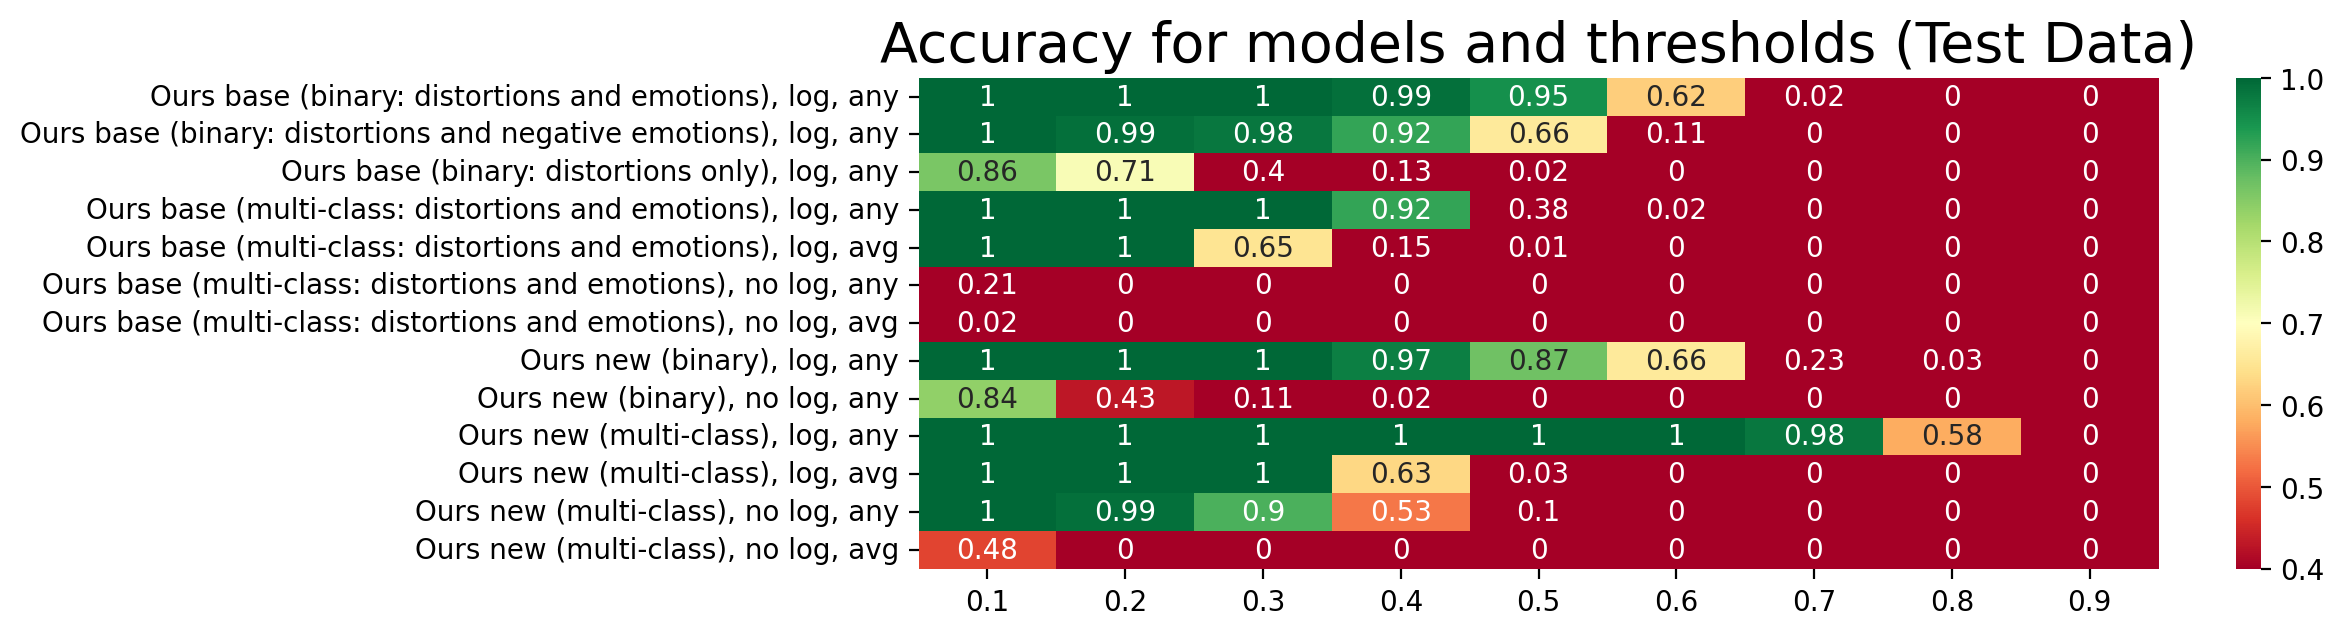

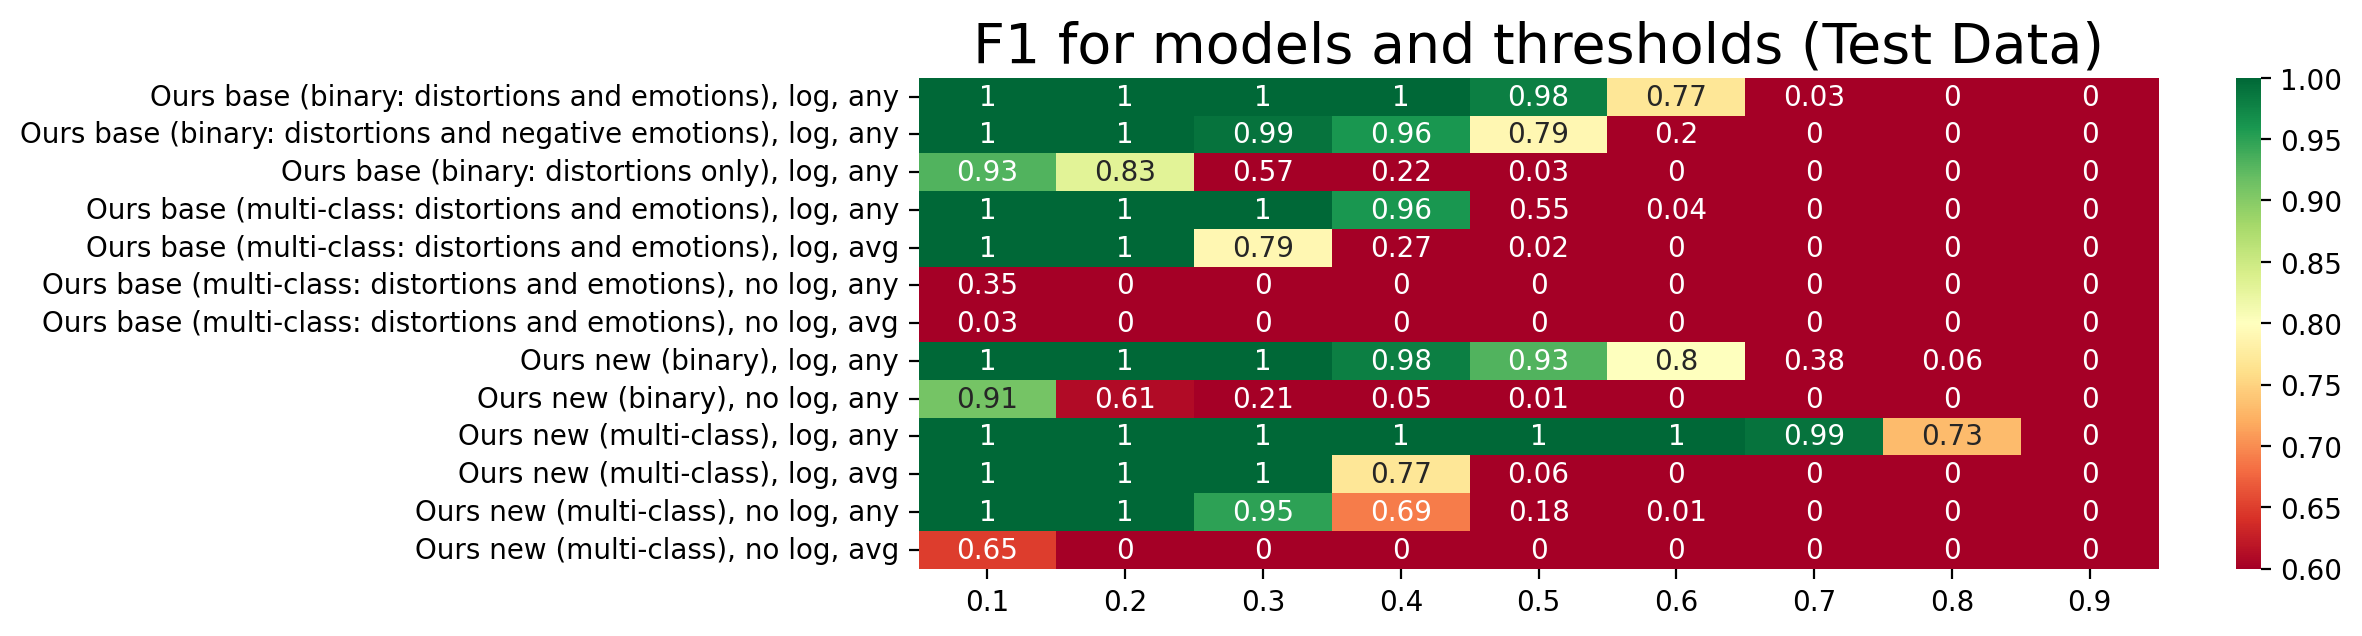

In [43]:
matrix_plot([m for m in models_results], thresholds, models_acc, 1.0, title = f'Accuracy for models and thresholds (Test Data)', 
            vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

matrix_plot([m for m in models_results], thresholds, models_f1, 1.0, title = f'F1 for models and thresholds (Test Data)', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

In [44]:
thresholds, models_results_a, models_acc_a, models_f1_a = test_evaluate_df(df3)


Ours base (binary: distortions and emotions), log, any
Ours base (binary: distortions and emotions), log 0.1 0.6245059288537549 0.7688564476885645
Ours base (binary: distortions and emotions), log 0.2 0.6245059288537549 0.7688564476885645
Ours base (binary: distortions and emotions), log 0.3 0.6245059288537549 0.7686312713102778
Ours base (binary: distortions and emotions), log 0.4 0.6197628458498023 0.7639842983316978
Ours base (binary: distortions and emotions), log 0.5 0.6173913043478261 0.7516675218060545
Ours base (binary: distortions and emotions), log 0.6 0.658498023715415 0.7262357414448669
Ours base (binary: distortions and emotions), log 0.7 0.5205533596837945 0.3968175037294878
Ours base (binary: distortions and emotions), log 0.8 0.3865612648221344 0.05481120584652862
Ours base (binary: distortions and emotions), log 0.9 0.3691699604743083 0.0012515644555694616
Ours base (binary: distortions and emotions), log 0.6 0.658498023715415 0.7262357414448669 1.229847 0.000486105533

Ours new (binary), no log 0.7 0.8739130434782608 0.8890434782608696
Ours new (binary), no log 0.8 0.8679841897233201 0.8832167832167832
Ours new (binary), no log 0.9 0.8612648221343874 0.8765388673935982
Ours new (binary), no log 0.2 0.9343873517786562 0.9466580976863752 1.377618 0.0005445130434782609
Ours new (multi-class), log, any
Ours new (multi-class), log 0.1 0.6312252964426878 0.7739277925854131
Ours new (multi-class), log 0.2 0.6312252964426878 0.7739277925854131
Ours new (multi-class), log 0.3 0.6312252964426878 0.7739277925854131
Ours new (multi-class), log 0.4 0.6312252964426878 0.7739277925854131
Ours new (multi-class), log 0.5 0.6312252964426878 0.7739277925854131
Ours new (multi-class), log 0.6 0.632806324110672 0.774678632064031
Ours new (multi-class), log 0.7 0.6529644268774704 0.7825656265477959
Ours new (multi-class), log 0.8 0.8075098814229249 0.852558280351196
Ours new (multi-class), log 0.9 0.46679841897233204 0.26883468834688345
Ours new (multi-class), log 0.8 0.8

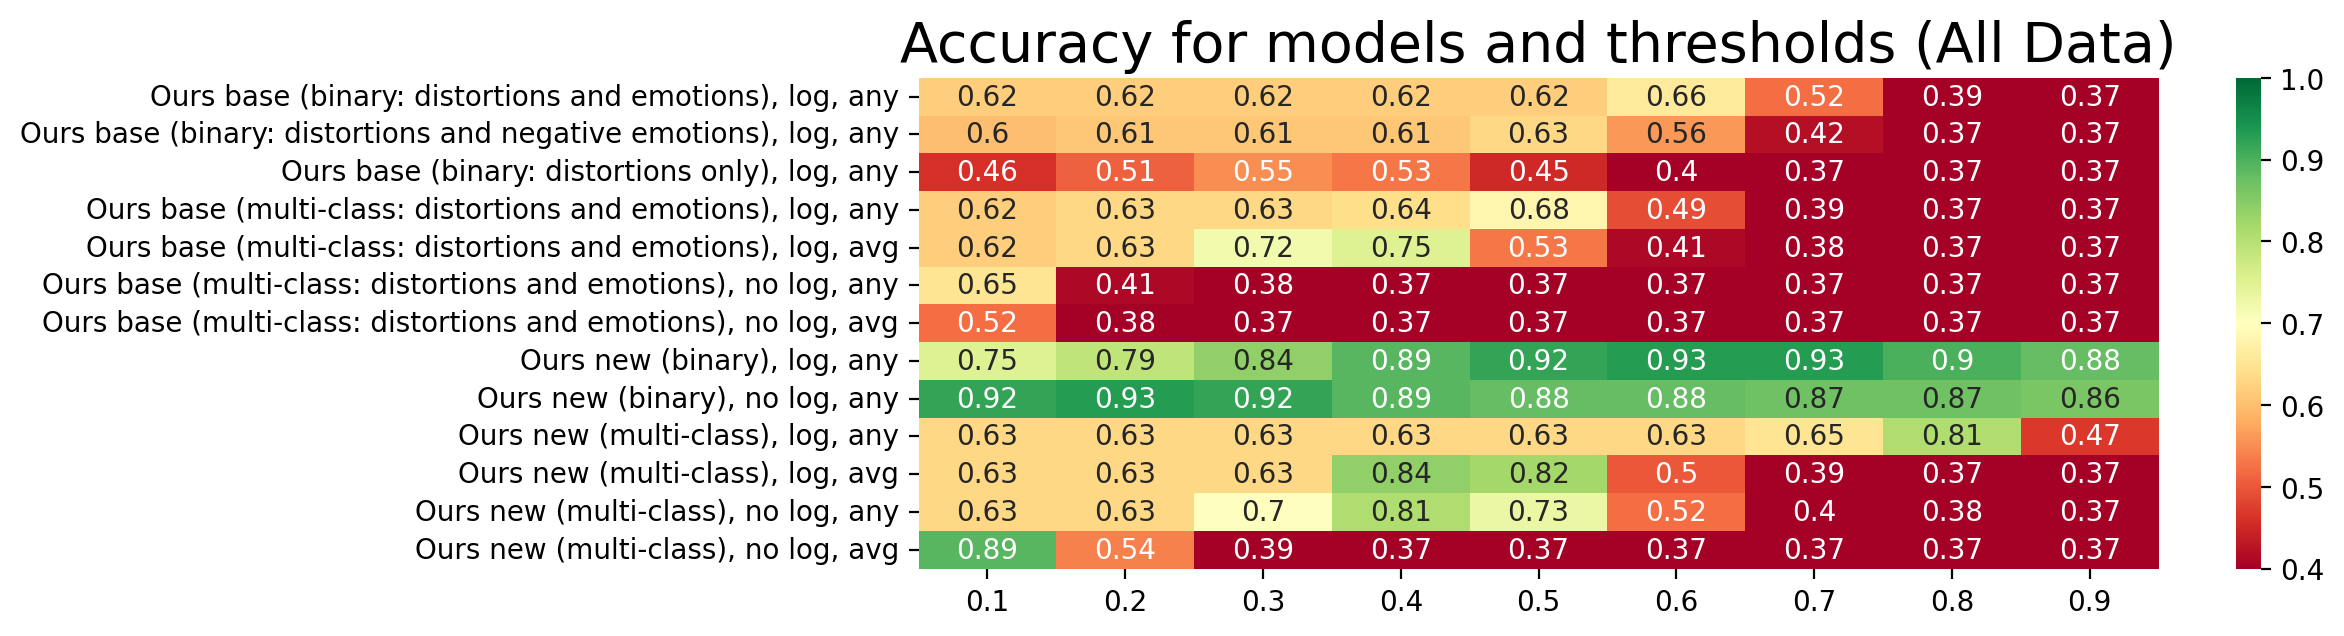

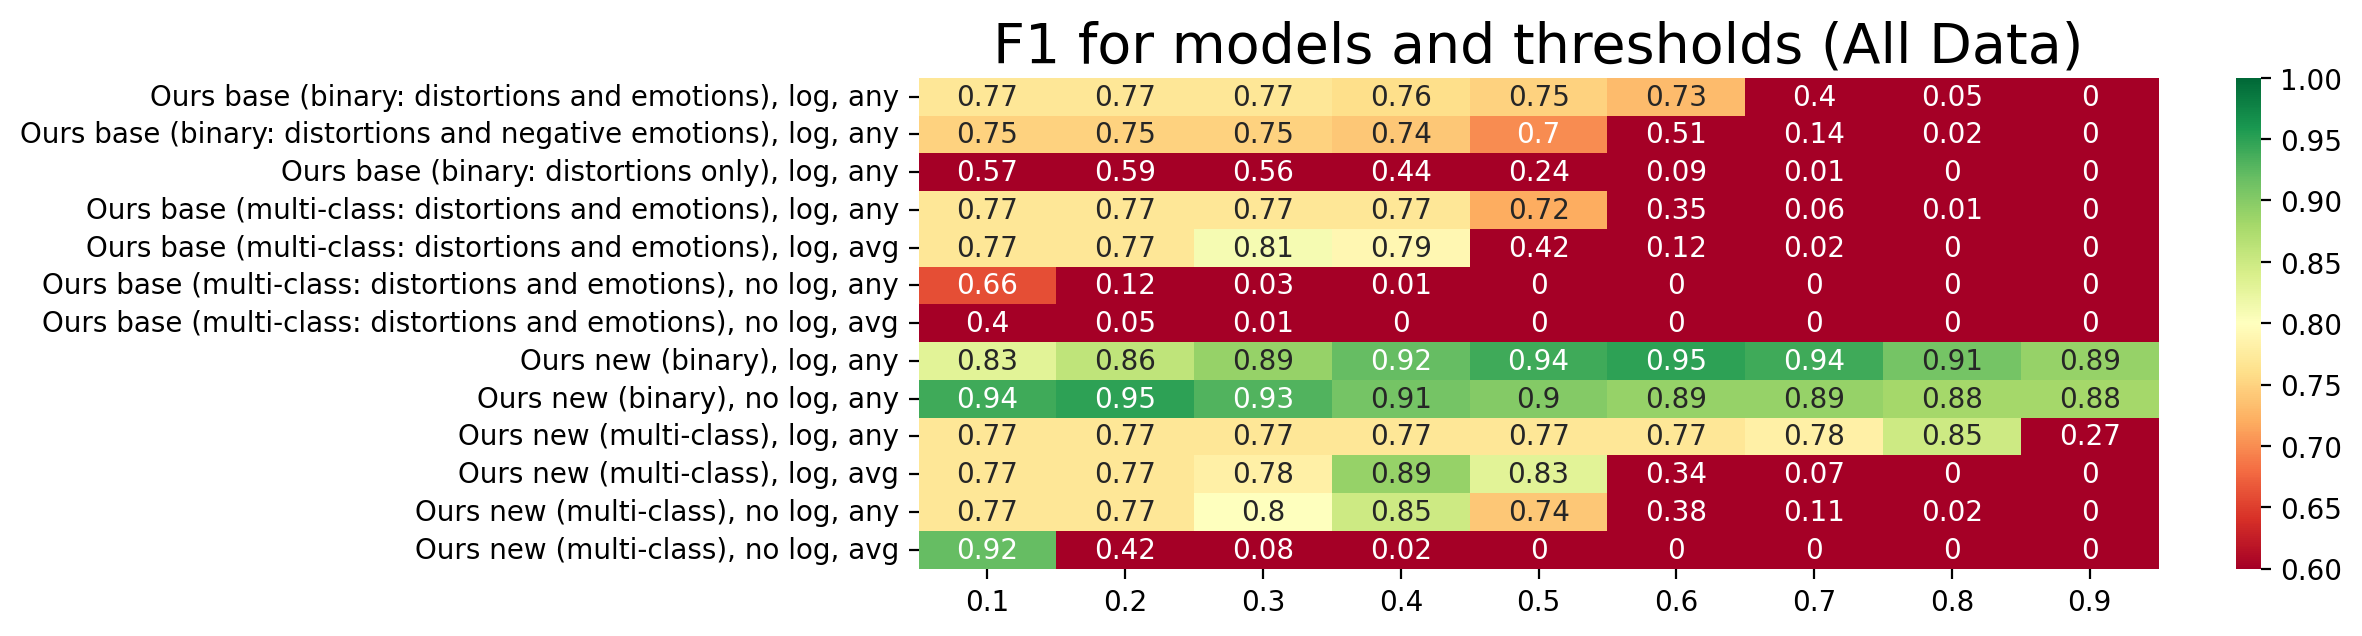

In [45]:
matrix_plot([m for m in models_results_a], thresholds, models_acc_a, 1.0, title = f'Accuracy for models and thresholds (All Data)', 
            vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

matrix_plot([m for m in models_results_a], thresholds, models_f1_a, 1.0, title = f'F1 for models and thresholds (All Data)', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

## Evaluate All "Ours New" Models on Splits to get "error bars"

In [53]:
#TODO add baseline evaluations


In [50]:
for m in models_results:
    model, evalname, best_t, best_acc, best_f1, seconds, seconds_per_item = models_results[m]
    model_t = f"{m} ({best_t})"
    t0 = dt.datetime.now()
    result = []
    lens = 0
    for df in df_tests:
        lens += len(df)
        evaluator = our_evaluator_tm_any if evalname == 'any' else our_evaluator_tm_avg
        acc, f1 = evaluate_tm_df_acc_f1(df,model,evaluator,best_t,debug=False)
        result.append((acc, f1))
    t1 = dt.datetime.now()
    delta = t1 - t0
    print(model_t,(result,delta.total_seconds(),delta.total_seconds()/len(df3)))
    results[model_t] = (result,delta.total_seconds(),delta.total_seconds()/len(df3))

Ours base (binary: distortions and emotions), log, any (0.1) ([(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)], 0.413412, 0.00016340395256916995)
Ours base (binary: distortions and negative emotions), log, any (0.1) ([(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)], 0.395121, 0.00015617430830039525)
Ours base (binary: distortions only), log, any (0.1) ([(0.8571428571428571, 0.923076923076923), (0.8452380952380952, 0.9161290322580644), (0.8823529411764706, 0.9375)], 0.354169, 0.00013998774703557313)
Ours base (multi-class: distortions and emotions), log, any (0.1) ([(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)], 0.896139, 0.00035420513833992097)
Ours base (multi-class: distortions and emotions), log, avg (0.1) ([(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)], 0.906398, 0.0003582600790513834)
Ours base (multi-class: distortions and emotions), no log, any (0.1) ([(0.17857142857142858, 0.30303030303030304), (0.2976190476190476, 0.4587155963302752), (0.15294117647058825, 0.2653061224489796)], 0.856162, 0.00033840395256916995)
Ours bas

In [52]:
#TODO add ours with "optimized" hyperparameters

In [54]:
#TODO add LLM 
# read results from pickle file saved by "comparing_llms.ipynb" notebook
file = open('llm_evaluation_results', 'rb')
llm_results = pickle.load(file)
file.close()
llm_results

{'llama3.2:3b': ([(0.7013372956909361, 0.8226992061158483),
   (0.6929172857850421, 0.8160237388724035),
   (0.6973749380881624, 0.8182088664088069)],
  598.925594,
  0.09888155753673436),
 'qwen2:7b': ([(0.7196631996037642, 0.8173014848289218),
   (0.7132243684992571, 0.8126819799417664),
   (0.7211490837048044, 0.8172671210645894)],
  700.087094,
  0.11558314247977547),
 'qwen2.5:7b': ([(0.6726102030708272, 0.7517837025910626),
   (0.662704309063893, 0.7438886799548702),
   (0.6978702327885091, 0.7689393939393939)],
  722.224972,
  0.11923806702988278),
 'qwen2.5:14b': ([(0.6726102030708272, 0.7517837025910626),
   (0.662704309063893, 0.7438886799548702),
   (0.6978702327885091, 0.7689393939393939)],
  3677.290473,
  0.6071141609707776)}

In [55]:
# decode LLM results to standard output
llm_f1 = {}
llm_acc = {}
for llm in llm_results:
    data = llm_results[llm]
    print(data)
    runs = data[0]
    acc_list = []
    f1_list = []
    for acc_f1 in data[0]:
        print(acc_f1)
        acc_list.append(acc_f1[0])
        f1_list.append(acc_f1[1])
    llm_f1[llm] = f1_list
    llm_acc[llm] = acc_list
for llm in llm_results:
    print("f1",llm_f1[llm],"acc",llm_acc[llm],"secons/text",round(llm_results[llm][2],2),"model",llm)


([(0.7013372956909361, 0.8226992061158483), (0.6929172857850421, 0.8160237388724035), (0.6973749380881624, 0.8182088664088069)], 598.925594, 0.09888155753673436)
(0.7013372956909361, 0.8226992061158483)
(0.6929172857850421, 0.8160237388724035)
(0.6973749380881624, 0.8182088664088069)
([(0.7196631996037642, 0.8173014848289218), (0.7132243684992571, 0.8126819799417664), (0.7211490837048044, 0.8172671210645894)], 700.087094, 0.11558314247977547)
(0.7196631996037642, 0.8173014848289218)
(0.7132243684992571, 0.8126819799417664)
(0.7211490837048044, 0.8172671210645894)
([(0.6726102030708272, 0.7517837025910626), (0.662704309063893, 0.7438886799548702), (0.6978702327885091, 0.7689393939393939)], 722.224972, 0.11923806702988278)
(0.6726102030708272, 0.7517837025910626)
(0.662704309063893, 0.7438886799548702)
(0.6978702327885091, 0.7689393939393939)
([(0.6726102030708272, 0.7517837025910626), (0.662704309063893, 0.7438886799548702), (0.6978702327885091, 0.7689393939393939)], 3677.290473, 0.6071

In [ ]:
#TODO plot 

In [ ]:
tms = {}
for split in splits:
    tms[split] = TextMetrics(language_metrics('',['Distortion'],
        path='../../data/models/distortions/split_combined/binary_view/'+split+'/'),
        metric_logarithmic=True,debug=False,encoding="utf-8")

splitB_best_acc_log = None
splitB_best_f1_log = None
best_acc = 0
best_threshold = 0
for threshold in thresholds:
    acc = []
    f1 = []
    for split in splits:
        df = splits[split][1]
        tm = tms[split]
        acc_aM, f1_aM = evaluate_tm_df_acc_f1(df,tm,our_evaluator_tm_any,threshold)
        acc.append(acc_aM)
        f1.append(f1_aM)
    print(threshold,"f1",f1,"acc",acc)
    avgacc = sum(acc) / len(acc)
    if avgacc > best_acc:
        best_acc = avgacc
        best_threshold = threshold
        splitB_best_f1_log = f1
        splitB_best_acc_log = acc
print()
print(best_threshold,"f1",splitB_best_f1_log,"acc",splitB_best_acc_log)

In [ ]:
tms = {}
for split in splits:
    tms[split] = TextMetrics(language_metrics('',['Distortion'],
        path='../../data/models/distortions/split_combined/binary_view/'+split+'/'),
        metric_logarithmic=False,debug=False,encoding="utf-8")

splitB_best_acc_nolog = None
splitB_best_f1_nolog = None
best_acc = 0
best_threshold = 0
for threshold in thresholds:
    acc = []
    f1 = []
    for split in splits:
        df = splits[split][1]
        tm = tms[split]
        acc_aM, f1_aM = evaluate_tm_df_acc_f1(df,tm,our_evaluator_tm_any,threshold)
        acc.append(acc_aM)
        f1.append(f1_aM)
    print(threshold,"f1",f1,"acc",acc)
    avgacc = sum(acc) / len(acc)
    if avgacc > best_acc:
        best_acc = avgacc
        best_threshold = threshold
        splitB_best_f1_nolog = f1
        splitB_best_acc_nolog = acc
print()
print(best_threshold,"f1",splitB_best_f1_nolog,"acc",splitB_best_acc_nolog)

In [ ]:
tms = {}
for split in splits:
    tms[split] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/split_combined/multiclass_view/'+split+'/'),
                                            metric_logarithmic=True,debug=False,encoding="utf-8")

splitM_best_acc_log = None
splitM_best_f1_log = None
best_acc = 0
best_threshold = 0
for threshold in thresholds:
    acc = []
    f1 = []
    for split in splits:
        df = splits[split][1]
        tm = tms[split]
        acc_aM, f1_aM = evaluate_tm_df_acc_f1(df,tm,our_evaluator_tm_avg,threshold)
        acc.append(acc_aM)
        f1.append(f1_aM)
    print(threshold,"f1",f1,"acc",acc)
    avgacc = sum(acc) / len(acc)
    if avgacc > best_acc:
        best_acc = avgacc
        best_threshold = threshold
        splitM_best_f1_log = f1
        splitM_best_acc_log = acc
print()
print(best_threshold,"f1",splitM_best_f1_log,"acc",splitM_best_acc_log)

In [ ]:
tms = {}
for split in splits:
    tms[split] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/split_combined/multiclass_view/'+split+'/'),
                                            metric_logarithmic=False,debug=False,encoding="utf-8")

splitM_best_acc_nolog = None
splitM_best_f1_nolog = None
best_acc = 0
best_threshold = 0
for threshold in thresholds:
    acc = []
    f1 = []
    for split in splits:
        df = splits[split][1]
        tm = tms[split]
        acc_aM, f1_aM = evaluate_tm_df_acc_f1(df,tm,our_evaluator_tm_avg,threshold)
        acc.append(acc_aM)
        f1.append(f1_aM)
    print(threshold,"f1",f1,"acc",acc)
    avgacc = sum(acc) / len(acc)
    if avgacc > best_acc:
        best_acc = avgacc
        best_threshold = threshold
        splitM_best_f1_nolog = f1
        splitM_best_acc_nolog = acc
print()
print(best_threshold,"f1",splitM_best_f1_nolog,"acc",splitM_best_acc_nolog)

## Load LLM performance data generated by "comparing_llms.ipynb" notebook

In [19]:
# read results from pickle file saved by "comparing_llms.ipynb" notebook
file = open('llm_evaluation_results', 'rb')
llm_results = pickle.load(file)
file.close()
llm_results

{'llama3.2:3b': ([(0.7013372956909361, 0.8226992061158483),
   (0.6929172857850421, 0.8160237388724035),
   (0.6973749380881624, 0.8182088664088069)],
  598.925594,
  0.09888155753673436),
 'qwen2:7b': ([(0.7196631996037642, 0.8173014848289218),
   (0.7132243684992571, 0.8126819799417664),
   (0.7211490837048044, 0.8172671210645894)],
  700.087094,
  0.11558314247977547),
 'qwen2.5:7b': ([(0.6726102030708272, 0.7517837025910626),
   (0.662704309063893, 0.7438886799548702),
   (0.6978702327885091, 0.7689393939393939)],
  722.224972,
  0.11923806702988278),
 'qwen2.5:14b': ([(0.6726102030708272, 0.7517837025910626),
   (0.662704309063893, 0.7438886799548702),
   (0.6978702327885091, 0.7689393939393939)],
  3677.290473,
  0.6071141609707776)}

In [20]:
# decode LLM results to standard output
llm_f1 = {}
llm_acc = {}
for llm in llm_results:
    data = llm_results[llm]
    print(data)
    runs = data[0]
    acc_list = []
    f1_list = []
    for acc_f1 in data[0]:
        print(acc_f1)
        acc_list.append(acc_f1[0])
        f1_list.append(acc_f1[1])
    llm_f1[llm] = f1_list
    llm_acc[llm] = acc_list
for llm in llm_results:
    print("f1",llm_f1[llm],"acc",llm_acc[llm],"secons/text",round(llm_results[llm][2],2),"model",llm)


([(0.7013372956909361, 0.8226992061158483), (0.6929172857850421, 0.8160237388724035), (0.6973749380881624, 0.8182088664088069)], 598.925594, 0.09888155753673436)
(0.7013372956909361, 0.8226992061158483)
(0.6929172857850421, 0.8160237388724035)
(0.6973749380881624, 0.8182088664088069)
([(0.7196631996037642, 0.8173014848289218), (0.7132243684992571, 0.8126819799417664), (0.7211490837048044, 0.8172671210645894)], 700.087094, 0.11558314247977547)
(0.7196631996037642, 0.8173014848289218)
(0.7132243684992571, 0.8126819799417664)
(0.7211490837048044, 0.8172671210645894)
([(0.6726102030708272, 0.7517837025910626), (0.662704309063893, 0.7438886799548702), (0.6978702327885091, 0.7689393939393939)], 722.224972, 0.11923806702988278)
(0.6726102030708272, 0.7517837025910626)
(0.662704309063893, 0.7438886799548702)
(0.6978702327885091, 0.7689393939393939)
([(0.6726102030708272, 0.7517837025910626), (0.662704309063893, 0.7438886799548702), (0.6978702327885091, 0.7689393939393939)], 3677.290473, 0.6071

# Evaluate Overall Results (Compiled)

## Check "biased" F1 for datasets

In [ ]:
def binary_df_bias(df):
    no = 0
    yes = 0
    err = 0
    for _, row in df.iterrows():
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        if primary_distortion == 'No Distortion':
            no += 1
        else:
            yes += 1
    return yes, no

yes, no = binary_df_bias(df3)
print(yes,no,yes+no,len(df3),yes/(yes+no))

for n in range(3):
    df = df3s[n]
    yes, no = binary_df_bias(df)
    print('unbalanced F1',f1_from_counts(yes, 0, no, 0))

## Compile all experimental results above

In [ ]:
f1_list = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
acc_list = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
model_list = []
for n in range(3):
    df = df3s[n]
    acc_t, f1_t = evaluate_tm_df_acc_f1(df,None,our_evaluator_tm_true,0)
    acc_f, f1_f = evaluate_tm_df_acc_f1(df,None,our_evaluator_tm_false,0)
    acc_r, f1_r = evaluate_tm_df_acc_f1(df,None,our_evaluator_tm_random,0)
    acc_BMLV, f1_BMLV = evaluate_tm_df_acc_f1(df,models['Ours base (multi-class: distortions and emotions), log'],our_evaluator_tm_avg,0.4)
    acc_NBLN, f1_NBLN = evaluate_tm_df_acc_f1(df,models['Ours new (binary), log'],our_evaluator_tm_any,0.6)
    acc_NBNN, f1_NBNN = evaluate_tm_df_acc_f1(df,models['Ours new (binary), no log'],our_evaluator_tm_any,0.6)
    acc_NMLN, f1_NMLN = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class), log'],our_evaluator_tm_any,0.6)
    acc_NMNN, f1_NMNN = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class), no log'],our_evaluator_tm_any,0.6)
    acc_NMLV, f1_NMLV = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class), log'],our_evaluator_tm_avg,0.6)
    acc_NMNV, f1_NMNV = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class), no log'],our_evaluator_tm_avg,0.6)

    acc_NBLNJ, f1_NBLNJ = evaluate_tm_df_acc_f1(df,models['Ours new (binary, joint), log'],our_evaluator_tm_any,0.5)
    acc_NBNNJ, f1_NBNNJ = evaluate_tm_df_acc_f1(df,models['Ours new (binary, joint), no log'],our_evaluator_tm_any,0.1)
    acc_NMLNJ, f1_NMLNJ = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class, joint), log'],our_evaluator_tm_any,0.9)
    acc_NMLVJ, f1_NMLVJ = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class, joint), log'],our_evaluator_tm_avg,0.8)
    acc_NMNNJ, f1_NMNNJ = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class, joint), no log'],our_evaluator_tm_any,0.5)
    acc_NMNVJ, f1_NMNVJ = evaluate_tm_df_acc_f1(df,models['Ours new (multi-class, joint), no log'],our_evaluator_tm_avg,0.5)
    
    f1_list[0].append(f1_t),     acc_list[0].append(acc_t)       
    f1_list[1].append(f1_f),     acc_list[1].append(acc_f)
    f1_list[2].append(f1_r),     acc_list[2].append(acc_r)                                                 
    f1_list[3].append(f1_BMLV),  acc_list[3].append(acc_BMLV)
    f1_list[4].append(f1_NBLN),  acc_list[4].append(acc_NBLN)
    f1_list[5].append(f1_NBNN),  acc_list[5].append(acc_NBNN)
    f1_list[6].append(f1_NMLN),  acc_list[6].append(acc_NMLN)
    f1_list[7].append(f1_NMNN),  acc_list[7].append(acc_NMNN)
    f1_list[8].append(f1_NMLV),  acc_list[8].append(acc_NMLV)
    f1_list[9].append(f1_NMNV),  acc_list[9].append(acc_NMNV)
    f1_list[10].append(f1_NBLNJ),  acc_list[10].append(acc_NBLNJ)
    f1_list[11].append(f1_NBNNJ),  acc_list[11].append(acc_NBNNJ)
    f1_list[12].append(f1_NMLNJ),  acc_list[12].append(acc_NMLNJ)
    f1_list[13].append(f1_NMLVJ),  acc_list[13].append(acc_NMLVJ)
    f1_list[14].append(f1_NMNNJ),  acc_list[14].append(acc_NMNNJ)
    f1_list[15].append(f1_NMNVJ),  acc_list[15].append(acc_NMNVJ)

model_list.append('Const(True)')
model_list.append('Const(False)')
model_list.append('Random')
model_list.append('OursBMLV(0.4)')
model_list.append('OursNBLN(0.6)')
model_list.append('OursNBNN(0.6)')
model_list.append('OursNMLN(0.6)')
model_list.append('OursNMNN(0.6)')
model_list.append('OursNMLV(0.6)')
model_list.append('OursNMNV(0.6)')
model_list.append('OursNBLN*(0.5)')
model_list.append('OursNBNN*(0.1)')
model_list.append('OursNMLN*(0.9)')
model_list.append('OursNMLV*(0.8)')
model_list.append('OursNMNN*(0.5)')
model_list.append('OursNMNV*(0.5)')

# add cross-split evaluations
f1_list.append(splitB_best_f1_log),   acc_list.append(splitB_best_acc_log),   model_list.append('OursNBLN**(0.7)')
f1_list.append(splitB_best_f1_nolog), acc_list.append(splitB_best_acc_nolog), model_list.append('OursNBNN**(0.2)')
f1_list.append(splitM_best_f1_log),   acc_list.append(splitM_best_acc_log),   model_list.append('OursNMLV**(0.5)')
f1_list.append(splitM_best_f1_nolog), acc_list.append(splitM_best_acc_nolog), model_list.append('OursNMNV**(0.2)')
               
for llm in llm_results:
    f1_list.append(llm_f1[llm])
    acc_list.append(llm_acc[llm])
    model_list.append(llm)

print("model:",model_list)
print()
print("f1:",f1_list)
print()
print("acc:",acc_list)


In [ ]:
f1_avg = []
f1_err = []
f1_error = {}
for i in range(len(model_list)):
    v_min, v_max, v_avg, v_mpe = agg_min_max_avg_mpe(f1_list[i])
    average = round(sum(f1_list[i])/3,3)
    a_min = min(f1_list[i])
    a_max = max(f1_list[i])
    f1_avg.append(average)
    f1_err.append(round(v_mpe,1))
    f1_error[average] = {'max':a_max,'min':a_min}
f1_error  

In [ ]:
acc_avg = []
acc_err = []
acc_error = {}
for i in range(len(model_list)):
    v_min, v_max, v_avg, v_mpe = agg_min_max_avg_mpe(acc_list[i])
    average = round(sum(acc_list[i])/3,3)
    a_min = min(acc_list[i])
    a_max = max(acc_list[i])
    acc_avg.append(average)
    acc_err.append(round(v_mpe,1))
    acc_error[average] = {'max':a_max,'min':a_min}
acc_error 

In [ ]:
df = pd.DataFrame({'Model':model_list,'Accuracy':acc_avg,'MPE(Accuracy),%':acc_err,'F1':f1_avg,'MPE(F1),%':f1_err})
df

In [ ]:
df['Accuracy'].corr(df['F1'])

In [ ]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

# Sample data
x = np.arange(10)
y = 5 * x + 10
x = df['Accuracy'].to_numpy()
y = df['F1'].to_numpy()

# Fit with polyfit
b, m = polyfit(x, y, 1)

# plt.plot(x, y, '.')
# plt.plot(x, b + m * x, '-')
plt.plot(x, y, '.', markersize=10)
plt.plot(x, b + m * x, '-', linewidth=2)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('F1', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

## Visualize Accuracy and F1 Results from different sources

In [ ]:
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.dpi"] = 300

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df.plot.bar(x='Model', y='Accuracy', ax=ax)
for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = acc_error[h]['min']  # use h to get min from dict z
    max_y = acc_error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df.plot.bar(x='Model', y='F1', ax=ax)
for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = f1_error[h]['min']  # use h to get min from dict z
    max_y = f1_error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

## Visualize Accuracy and F1 Results from the best selected sources

In [ ]:
selRows = df[(df['Model'] == 'OursNBNN(0.6)') | (df['Model'] == 'OursNMLN(0.6)')
            | (df['Model'] == 'OursNMLV(0.6)') | (df['Model'] == 'OursNMNV(0.6)')
            | (df['Model'] == 'OursNBLN*(0.5)') | (df['Model'] == 'OursNMLN*(0.9)') 
            | (df['Model'] == 'OursNMLV*(0.8)') | (df['Model'] == 'OursNMNV*(0.5)')
            | (df['Model'] == 'OursNBNN**(0.2)') | (df['Model'] == 'OursNMLV**(0.5)')].index
df_cut = df.drop(selRows, axis=0)
df_cut

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df_cut.plot.bar(x='Model', y='Accuracy', ax=ax)
for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = acc_error[h]['min']  # use h to get min from dict z
    max_y = acc_error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

ax.set_xlabel("Model", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df_cut.plot.bar(x='Model', y='F1', ax=ax)
for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = f1_error[h]['min']  # use h to get min from dict z
    max_y = f1_error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line
    
ax.set_xlabel("Model", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

## Visualize Runtime Performance Results from different sources
### Numbers substituted (manually) from cells 19 and 29

In [ ]:
plot_dict_bars({"Const(True)":0.0001,"Const(False)":0.0001,"Random":0.0001,"OursBM":0.0006,"OursNB":0.0002,"OursNM":0.0005,
                "LLM:llama3.2:3B":1.08,"LLM:qwen2:7B":2.03,"LLM:qwen2.5:7B":1.51,"LLM:qwen2:14B*":7.1}, 
               labels="Model", values="seconds/text", title=f"Seconds/text (runtime performance)")

ax = plt.gca()

ax.set_xlabel("Model", fontsize=14)
ax.set_title("Seconds/text (runtime performance)", fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)

In [ ]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)